In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
#we first need to understand the data in the measurement table
md = sqlalchemy.MetaData()
MeasurementTable = sqlalchemy.Table('Measurement', md, autoload=True, autoload_with=engine)
MeasurementColumns = MeasurementTable.c
for c in MeasurementColumns:
    print(c.name, c.type)

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
engine.execute("SELECT * FROM Measurement LIMIT 5").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [12]:
StationTable = sqlalchemy.Table('Station', md, autoload=True, autoload_with=engine)
StationColumns = StationTable.c
for c in StationColumns:
    print(c.name, c.type)

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
engine.execute("SELECT * FROM Station LIMIT 5").fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [14]:
# 1. Design a query to retrieve the last 12 months of precipitation data and plot the results

In [15]:
# 1a. Calculate the date 1 year ago from the last data point in the database
MaxDate=session.query(func.max(Measurement.date)).first()
print(MaxDate)

('2017-08-23',)


In [16]:
# 1b. Calculate the date 1 year ago from the last data point in the database
YearDate=dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(YearDate)

2016-08-23


In [17]:
# 1c. Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
          filter(Measurement.date.between('2016-08-23', '2017-08-23')).all()

In [18]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precip_df = pd.DataFrame(results)
precipmean_df = pd.DataFrame(precip.groupby(['date']).agg({'prcp':'mean'}))
precipmean_df.head()

NameError: name 'precip' is not defined

In [19]:
# Use Pandas Plotting with Matplotlib to plot the data
precipmean_df.plot(x_compat = True, figsize =(14, 5), rot = 90, color = "purple", legend = False)
plt.tight_layout()
plt.title("Daily Precip in Inches: Aug 23, 2016 - Aug 23, 2017")
plt.ylabel("Inches")
plt.xlabel("Date")
plt.xticks(rotation=25)
plt.savefig("dailyprecipitation.png")
plt.show()

NameError: name 'precipmean_df' is not defined

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [21]:
# Design a query to show how many stations are available in this dataset?
print("Total Station Count: "+ str(session.query(Station.station).count()))


Total Station Count: 9


In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
StationsCount = session.query(Measurement.station, func.count(Measurement.tobs)).\
       group_by(Measurement.station).order_by(func.sum(Measurement.tobs).desc()).all()
labels = ['Station', 'Observations']
stationscount_df = pd.DataFrame.from_records(StationsCount, columns=labels)
stationscount_df

,Station,Observations
0,USC00519397,2724
1,USC00519523,2669
2,USC00519281,2772
3,USC00513117,2709
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [23]:

# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
min_temp = session.query(func.min(Measurement.tobs)).filter_by(station = topstationid).scalar()
max_temp = session.query(func.max(Measurement.tobs)).filter_by(station = topstationid).scalar()
avg_temp = session.query(func.avg(Measurement.tobs)).filter_by(station = topstationid).scalar()
print("For Station ID "+ str(topstationid)+": " +
      f'Min Temp is {min_temp}, Max Temp is {max_temp}, and Avg Tempis {avg_temp}')

NameError: name 'topstationid' is not defined

In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_pd = pd.DataFrame(session.query(Measurement.tobs).filter(Measurement.date.between('2016-08-23', '2017-08-23'), Measurement.station == topstationid).all())
active_pd.plot.hist(bins=12, figsize=(10,8), legend = False)
plt.xlabel("Temprature")
plt.tight_layout()
plt.savefig("histogram.png")

NameError: name 'topstationid' is not defined

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    
    data = pd.DataFrame(session.query(Measurement.tobs).\
           filter(Measurement.date >= (pd.to_datetime(start_date)- dt.timedelta(days = 365)).strftime('%Y-%m-%d'),\
           Measurement.date < (pd.to_datetime(end_date)- dt.timedelta(days = 365)).strftime('%Y-%m-%d')).all())
    
    avg = round(data["tobs"].mean())
    low = data["tobs"].min()
    high = data["tobs"].max()
    
    print("Historical average temperature  for your vacation is: "+ str(avg) +" degrees")
    print("Historical low temperature for your vacation is: "+ str(low) +" degrees")
    print("Historical high temperature for your vacation is: "+ str(high) +" degrees")
    
    return avg, low, high

NameError: name 'average' is not defined

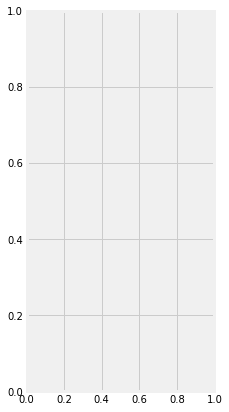

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize = (3,7))
ax.bar(1, average, color = 'lightgreen', edgecolor = 'black', yerr=(high - low), capsize = 7, label = 'test')
ax.set_xticklabels([])
plt.yticks(np.arange(0, average + 20, 10))
plt.title ("Historic Average Temperature for Trip")
plt.ylabel ("Temperature (F)")
plt.savefig("tripavgtemp.png")

In [28]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
